  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:15<00:00, 62.98it/s]


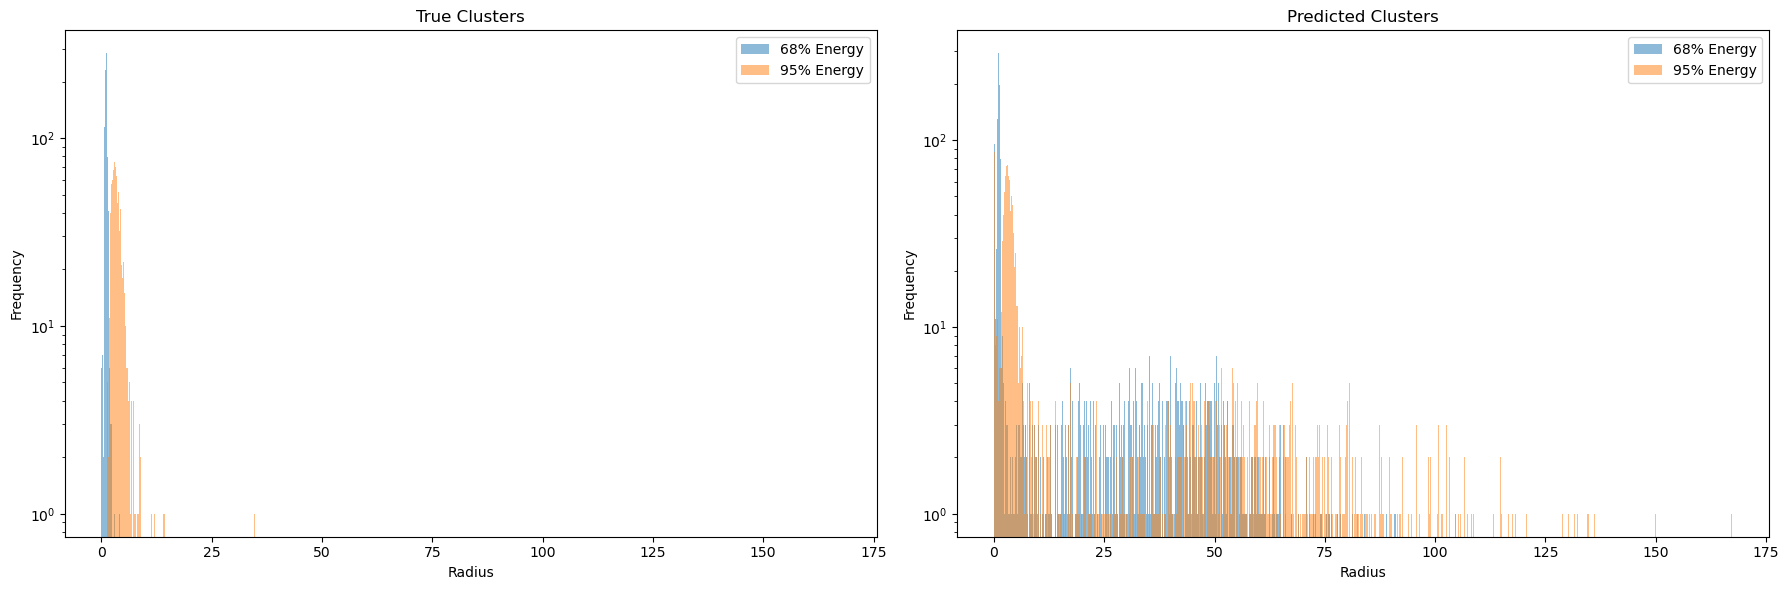

In [18]:
import pickle
import numpy as np
import torch
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set file pattern and file limit
file_pattern = r'C:\Users\tsoli\OneDrive\Documents\School\1 - University of Minnesota\Year 17\Year 1 Research\picklefiles\photons\*.pkl'
file_limit = 1000

# Layer positions for binning
layer_positions = [
    3.22e+02, 3.23e+02, 3.25e+02, 3.26e+02, 3.28e+02, 3.29e+02, 3.31e+02, 3.32e+02, 3.34e+02, 3.35e+02,
    3.37e+02, 3.38e+02, 3.40e+02, 3.41e+02, 3.43e+02, 3.44e+02, 3.46e+02, 3.47e+02, 3.49e+02, 3.50e+02,
    3.52e+02, 3.53e+02, 3.55e+02, 3.56e+02, 3.58e+02, 3.59e+02, 3.61e+02, 3.62e+02, 3.68e+02, 3.73e+02,
    3.79e+02, 3.84e+02, 3.89e+02, 3.95e+02, 4.00e+02, 4.06e+02, 4.11e+02, 4.17e+02, 4.22e+02, 4.28e+02,
    4.36e+02, 4.45e+02, 4.53e+02, 4.62e+02, 4.70e+02, 4.79e+02, 4.87e+02, 4.96e+02, 5.05e+02, 5.13e+02
]
layer_positions = np.array([int(pos) for pos in layer_positions])

# Load data from pkl files
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        score_noise_filter = pickle.load(f)
        pass_noise_filter = pickle.load(f)
        out_gravnet = pickle.load(f)
    return data, score_noise_filter, pass_noise_filter, out_gravnet

# Clustering algorithm from plots3D.
def get_clustering(beta, X, threshold_beta=0.2, threshold_dist=0.5):
    n_points = beta.shape[0]
    select_condpoints = beta > threshold_beta
    indices_condpoints = np.nonzero(select_condpoints)[0]
    indices_condpoints = indices_condpoints[np.argsort(-beta[select_condpoints])]
    unassigned = np.arange(n_points)
    clustering = -1 * np.ones(n_points, dtype=np.int32)
    
    for index_condpoint in indices_condpoints:
        d = np.linalg.norm(X[unassigned] - X[index_condpoint], axis=-1)
        assigned_to_this_condpoint = unassigned[d < threshold_dist]
        clustering[assigned_to_this_condpoint] = index_condpoint
        unassigned = unassigned[~(d < threshold_dist)]
    
    return clustering

# Parsing true input.
def process_data(data):
    true_energies = data.x[:, 0].numpy()
    true_clusters = data.y.numpy()
    xpos = data.x[:, 5].numpy()
    ypos = data.x[:, 6].numpy()
    zpos = data.x[:, 7].numpy()
    return true_energies, true_clusters, xpos, ypos, zpos

# Parsing network output.
def process_gravnet(score_noise_filter, pass_noise_filter, out_gravnet):
    beta = torch.sigmoid(out_gravnet[:, 0]).numpy()
    cluster_space_coords = out_gravnet[:, 1:].numpy()
    pred_clusters_pnf = get_clustering(beta, cluster_space_coords, threshold_beta=0.2, threshold_dist=0.5)
    pred_clusters = np.zeros_like(pass_noise_filter, dtype=np.int32)
    pred_clusters[pass_noise_filter] = pred_clusters_pnf
    
    # Count hits per cluster
    unique, counts = np.unique(pred_clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    
    # Create final_pred_hits with clusters having less than 100 hits labeled as -2
    final_pred_hits = np.array([cluster if cluster_counts[cluster] >= 100 else -2 for cluster in pred_clusters])
    
    return final_pred_hits

def find_nearest_layer(zpos, layer_positions):
    nearest_layers = np.array([layer_positions[np.argmin(np.abs(layer_positions - z))] for z in zpos])
    return nearest_layers

def calculate_com_and_radii(cluster_indices, xpos, ypos, energies):
    x_com = np.sum(xpos[cluster_indices] * energies[cluster_indices]) / np.sum(energies[cluster_indices])
    y_com = np.sum(ypos[cluster_indices] * energies[cluster_indices]) / np.sum(energies[cluster_indices])
    
    distances = np.sqrt((xpos[cluster_indices] - x_com)**2 + (ypos[cluster_indices] - y_com)**2)
    sorted_indices = np.argsort(distances)
    sorted_energies = energies[cluster_indices][sorted_indices]
    cumulative_energies = np.cumsum(sorted_energies)
    total_energy = cumulative_energies[-1]
    
    radius_68 = distances[sorted_indices][np.searchsorted(cumulative_energies, 0.68 * total_energy)]
    radius_95 = distances[sorted_indices][np.searchsorted(cumulative_energies, 0.95 * total_energy)]
    
    return radius_68, radius_95

def main():
    files = glob.glob(file_pattern)[:file_limit]

    radius_68_pred = []
    radius_95_pred = []
    radius_68_true = []
    radius_95_true = []

    for file_path in tqdm(files):
        data, score_noise_filter, pass_noise_filter, out_gravnet = load_data(file_path)
        true_energies, true_clusters, xpos, ypos, zpos = process_data(data)
        final_pred_hits = process_gravnet(score_noise_filter, pass_noise_filter, out_gravnet)
        
        # Identify the z-position with the most energy for each predicted cluster
        unique_pred_clusters = np.unique(final_pred_hits)
        for cluster in unique_pred_clusters:
            if cluster == -1 or cluster == 0 or cluster == -2:
                continue  # Skip noise points and clusters with less than 100 hits
            cluster_indices = np.where(final_pred_hits == cluster)[0]
            cluster_energies = true_energies[cluster_indices]
            cluster_zpos = zpos[cluster_indices]
            
            # Sum energies for each z-position
            zpos_energy_sum = {}
            for z, energy in zip(cluster_zpos, cluster_energies):
                if z in zpos_energy_sum:
                    zpos_energy_sum[z] += energy
                else:
                    zpos_energy_sum[z] = energy
            
            # Find the z-position with the highest total energy
            max_energy_z = max(zpos_energy_sum, key=zpos_energy_sum.get)
            chosen_layer_indices = cluster_indices[cluster_zpos == max_energy_z]
            
            # Calculate COM and radii for the chosen layer
            r68, r95 = calculate_com_and_radii(chosen_layer_indices, xpos, ypos, true_energies)
            radius_68_pred.append(r68)
            radius_95_pred.append(r95)

        # Identify the z-position with the most energy for each true cluster
        unique_true_clusters = np.unique(true_clusters)
        for cluster in unique_true_clusters:
            if cluster == 0:
                continue  # Skip noise points
            cluster_indices = np.where(true_clusters == cluster)[0]
            cluster_energies = true_energies[cluster_indices]
            cluster_zpos = zpos[cluster_indices]
            
            # Sum energies for each z-position
            zpos_energy_sum = {}
            for z, energy in zip(cluster_zpos, cluster_energies):
                if z in zpos_energy_sum:
                    zpos_energy_sum[z] += energy
                else:
                    zpos_energy_sum[z] = energy
            
            # Find the z-position with the highest total energy
            max_energy_z = max(zpos_energy_sum, key=zpos_energy_sum.get)
            chosen_layer_indices = cluster_indices[cluster_zpos == max_energy_z]
            
            # Calculate COM and radii for the chosen layer
            r68, r95 = calculate_com_and_radii(chosen_layer_indices, xpos, ypos, true_energies)
            radius_68_true.append(r68)
            radius_95_true.append(r95)
        
    # Plot histograms for 68% and 95% radii
    plt.figure(figsize=(18, 6))
    
    # Define common bin edges
    bin_edges = np.linspace(0, max(max(radius_68_true), max(radius_95_true), max(radius_68_pred), max(radius_95_pred)), 1000)
    
    # Plot histogram for true clusters
    plt.subplot(1, 2, 1)
    plt.hist(radius_68_true, bins=bin_edges, alpha=0.5, label='68% Energy')
    plt.hist(radius_95_true, bins=bin_edges, alpha=0.5, label='95% Energy')
    plt.xlabel('Radius')
    plt.ylabel('Frequency')
    plt.title('True Clusters')
    plt.legend()
    plt.yscale('log')
    
    # Plot histogram for predicted clusters
    plt.subplot(1, 2, 2)
    plt.hist(radius_68_pred, bins=bin_edges, alpha=0.5, label='68% Energy')
    plt.hist(radius_95_pred, bins=bin_edges, alpha=0.5, label='95% Energy')
    plt.xlabel('Radius')
    plt.ylabel('Frequency')
    plt.title('Predicted Clusters')
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()